# Notebook 1: Data exploration and EDA

**Objectives**:
- Load and validate all raw data files
- perform comprehensive exploratory data analysis
- understand data characteristics and quality issues
- compare volatility across assets
- learn from the data to potentially improve our futur deep learning models (for data preprocessing for example)

---

## Table of Contents

1. [Setup and Configuration](#1-setup-and-configuration)
2. [Load Data](#2-load-data)
3. [Data Quality Validation](#3-data-quality-validation)
4. [Basic Statistical Analysis](#4-basic-statistical-analysis)
5. [Price Visualization](#5-price-visualization)
6. [Returns Analysis](#6-returns-analysis)
7. [Volatility Analysis](#7-volatility-analysis)
8. [Correlation Analysis](#8-correlation-analysis)
9. [Stationarity Tests](#9-stationarity-tests)
10. [Autocorrelation Analysis](#10-autocorrelation-analysis)
11. [Summary and Key Findings](#11-summary-and-key-findings)

---

## 1. Setup and Configuration

In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
import warnings
import os
warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)

print("[OK] Libraries imported")

[OK] Libraries imported


In [206]:
# Configure plotting styles
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

print("[OK] Plotting configuration")

[OK] Plotting configuration


In [207]:
# Define paths and constants
DATA_DIR = '../data_new/data_raw/'
RESULTS_DIR = '../results/'
FIGURES_DIR = '../results/figures/eda/'

# Asset information
ASSETS = {
    'AAPL': {'name': 'Apple Inc.', 'type': 'Tech Stock', 'volatility': 'Low-Medium'},
    'AMZN': {'name': 'Amazon.com Inc.', 'type': 'Tech Stock', 'volatility': 'Medium'},
    'NVDA': {'name': 'NVIDIA Corporation', 'type': 'Tech Stock', 'volatility': 'Medium-High'},
    'SPY': {'name': 'S&P 500 ETF', 'type': 'Index ETF', 'volatility': 'Low'},
    'BTC-USD': {'name': 'Bitcoin', 'type': 'Cryptocurrency', 'volatility': 'Very High'}
}

# File mapping
FILE_NAMES = {
    'AAPL': 'AAPL_1daily_yfinance.csv',
    'AMZN': 'AMZN_1daily_yfinance.csv',
    'NVDA': 'NVDA_1daily_yfinance.csv',
    'SPY': 'SPY_1daily_yfinance.csv',
    'BTC-USD': 'BTC_USD_1daily_yfinance.csv'
}

print("[OK] Configuration")


[OK] Configuration


## 2. Load Data

We load all 5 CSV files containing daily for AAPL, AMZN, NVDA, SPY, and BTC-USD.

 The data was obtained thanks to the Yahoo finance API (yfinance). Each row contains at least the OHLCV data (open, high, low, close, volume) for each asset for 1 day. We were able to get historical data up to 01/01/2000 for all assets except bitcoin since it became available on exchanges around 2014.

In [208]:
# Load all asset data
data = {}

for asset, filename in FILE_NAMES.items():
    filepath = os.path.join(DATA_DIR, filename)
    
    try:
        df = pd.read_csv(filepath, index_col=0, parse_dates=True)
        data[asset] = df
        print(f"[OK] Loaded {asset}: {len(df)} days")
    except FileNotFoundError:
        print(f"[ERROR] File not found: {filepath}")
        data[asset] = None
    except Exception as e:
        print(f"[ERROR] Error loading {asset}: {e}")
        data[asset] = None

print(f"\n[OK] Successfully loaded {sum(1 for v in data.values() if v is not None)}/{len(ASSETS)} assets")

[OK] Loaded AAPL: 6522 days
[OK] Loaded AMZN: 6522 days
[OK] Loaded NVDA: 6522 days
[OK] Loaded SPY: 6522 days
[OK] Loaded BTC-USD: 4101 days

[OK] Successfully loaded 5/5 assets


In [209]:
# Display basic information for each dataset
print("="*70)
print("DATASET OVERVIEW")
print("="*70)

for asset, df in data.items():
    if df is not None:
        years = (df.index.max() - df.index.min()).days / 365.25
        print(f"\n{asset} ({ASSETS[asset]['name']}):")
        print(f"  Date Range: {df.index.min().date()} to {df.index.max().date()}")
        print(f"  Total Days: {len(df)}")
        print(f"  Years Covered: {years:.1f} years")
        print(f"  Columns: {list(df.columns)}")
        print(f"  Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

DATASET OVERVIEW

AAPL (Apple Inc.):
  Date Range: 2000-01-03 to 2025-12-05
  Total Days: 6522
  Years Covered: 25.9 years
  Columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
  Memory Usage: 0.40 MB

AMZN (Amazon.com Inc.):
  Date Range: 2000-01-03 to 2025-12-05
  Total Days: 6522
  Years Covered: 25.9 years
  Columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
  Memory Usage: 0.40 MB

NVDA (NVIDIA Corporation):
  Date Range: 2000-01-03 to 2025-12-05
  Total Days: 6522
  Years Covered: 25.9 years
  Columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
  Memory Usage: 0.40 MB

SPY (S&P 500 ETF):
  Date Range: 2000-01-03 to 2025-12-05
  Total Days: 6522
  Years Covered: 25.9 years
  Columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Capital Gains']
  Memory Usage: 0.45 MB

BTC-USD (Bitcoin):
  Date Range: 2014-09-17 to 2025-12-08
  Total Days: 4101
  Years Covered: 11.2 y

## 3. Data Quality Validation

Check for missing values, duplicates, and other data quality issues.

In [210]:
# Check for missing values and data quality issues
print("="*70)
print("DATA QUALITY REPORT")
print("="*70)

quality_summary = []

for asset, df in data.items():
    if df is not None:
        print(f"\n{asset}:")
        
        # Missing values
        missing = df.isnull().sum()
        missing_pct = (missing / len(df) * 100).round(2)
        
        if missing.sum() > 0:
            print(f"  Missing values found:")
            for col in missing[missing > 0].index:
                print(f"    - {col}: {missing[col]} ({missing_pct[col]}%)")
        else:
            print(f"  No missing values")
        
        # Check for duplicates
        duplicates = df.index.duplicated().sum()
        if duplicates > 0:
            print(f"  Duplicate timestamps: {duplicates}")
        else:
            print(f"  No duplicate timestamps")
        
        # Check for negative values in price/volume
        neg_prices = (df['Close'] <= 0).sum()
        if neg_prices > 0:
            print(f"  Negative/zero prices: {neg_prices}")
        else:
            print(f"  All prices positive")
        
        zero_volume = (df['Volume'] == 0).sum()
        if zero_volume > 0:
            print(f"  Zero volume records: {zero_volume} ({zero_volume/len(df)*100:.2f}%)")
        
        quality_summary.append({
            'Asset': asset,
            'Total_Records': len(df),
            'Missing_Values': missing.sum(),
            'Duplicates': duplicates,
            'Zero_Volume': zero_volume
        })

# Create summary DataFrame
quality_df = pd.DataFrame(quality_summary)
print("\n" + "="*70)
print("QUALITY SUMMARY")
print("="*70)
print(quality_df.to_string(index=False))

DATA QUALITY REPORT

AAPL:
  No missing values
  No duplicate timestamps
  All prices positive

AMZN:
  No missing values
  No duplicate timestamps
  All prices positive

NVDA:
  No missing values
  No duplicate timestamps
  All prices positive

SPY:
  No missing values
  No duplicate timestamps
  All prices positive

BTC-USD:
  No missing values
  No duplicate timestamps
  All prices positive

QUALITY SUMMARY
  Asset  Total_Records  Missing_Values  Duplicates  Zero_Volume
   AAPL           6522               0           0            0
   AMZN           6522               0           0            0
   NVDA           6522               0           0            0
    SPY           6522               0           0            0
BTC-USD           4101               0           0            0
  No missing values
  No duplicate timestamps
  All prices positive

NVDA:
  No missing values
  No duplicate timestamps
  All prices positive

SPY:
  No missing values
  No duplicate timestamps
  All p

The data is very clean with no issue at all. 
- No missing values across all assets
- No duplicate timestamps
- All prices are positive
- There are no zero volume values (there is not a day where the ticker has not been traded)

## 4. Basic Statistical Analysis

Calculate descriptive statistics for each asset.

In [211]:
# Descriptive statistics for close prices
print("="*70)
print("DESCRIPTIVE STATISTICS - CLOSE PRICES")
print("="*70)

stats_summary = []

for asset, df in data.items():
    if df is not None:
        close_prices = df['Close']
        
        stats_summary.append({
            'Asset': asset,
            'Mean': close_prices.mean(),
            'Median': close_prices.median(),
            'Std': close_prices.std(),
            'Min': close_prices.min(),
            'Max': close_prices.max(),
            'Range': close_prices.max() - close_prices.min(),
            'CV (%)': (close_prices.std() / close_prices.mean() * 100) 
        })

stats_df = pd.DataFrame(stats_summary)
print(stats_df.to_string(index=False))

# Display distribution statistics
print("\n" + "="*70)
print("PRICE DISTRIBUTION ANALYSIS")
print("="*70)

for asset, df in data.items():
    if df is not None:
        print(f"\n{asset}:")
        print(f"Skewness: {df['Close'].skew():.4f}")
        print(f"Kurtosis: {df['Close'].kurtosis():.4f}")

DESCRIPTIVE STATISTICS - CLOSE PRICES
  Asset         Mean       Median          Std        Min           Max         Range     CV (%)
   AAPL    47.807490    15.711965    68.560911   0.196741    286.190002    285.993261 143.410397
   AMZN    49.971971    12.825000    65.669045   0.298500    254.000000    253.701500 131.411757
   NVDA    13.621613     0.464775    35.191800   0.056309    207.028473    206.972164 258.352655
    SPY   195.821749   115.967823   151.639176  50.092178    687.390015    637.297836  77.437352
BTC-USD 26503.253883 10666.482422 31400.655528 178.102997 124752.531250 124574.428253 118.478492

PRICE DISTRIBUTION ANALYSIS

AAPL:
Skewness: 1.5464
Kurtosis: 1.1039

AMZN:
Skewness: 1.2466
Kurtosis: 0.2409

NVDA:
Skewness: 3.3549
Kurtosis: 10.7645

SPY:
Skewness: 1.3267
Kurtosis: 0.8190

BTC-USD:
Skewness: 1.3649
Kurtosis: 0.9245


We learn a lot of things from these basic statistics:

**Regarding price levels:**

- **Traditional Stocks**: AAPL, AMZN, and NVDA show enormous growth ranges reflecting long-term upward trend.
- **SPY**: ($50.09-$687.39) represents steady S&P 500 index growth with lower relative volatility compared to the other assets
- **BTC-USD**: shows extreme price levels and variability especially compared to the other assets.

**Regarding coefficient of variation:** 

CV = standard deviation / mean . It a coefficient that measures the relative dispersion. Dividing the deviation by the mean allows the comparaison between different series. It is useful in our case since our assets do not have the same scale and range.
- **SPY** (77.4% CV): It is the lowest relative volatility compared to the others. It can be explained by the fact that it is a diversified index and it provides stability.
- **BTC-USD** (118.5% CV): High relative volatility despite higher absolute prices. It is a highly speculative asset that is very sensible.
- **AAPL** (143.4% CV) and **AMZN** (131.4% CV): Moderate relative volatility for large-cap tech stocks. 
- **NVDA** (258.4% CV): Highest relative volatility. It can be explained by the recent explosive AI sector growth.

**Regarding the distribution:**:

- The skewness reflects the asymmetry of the distribution. Having a positive skewness means there are common positive outliers (fat right tail). A negative value means the same thing but for the left side. All assets have a **positive skewness value** (1.25-3.35): Right-skewed distributions with long upper tails, indicates that prices spent more time at lower levels with occasional explosive rallies. NVDA's extreme skewness (3.35) reflects its extraordinary growth trajectory.
- The kurtosis shows the tail heaviness and peakness. A positive kurtosis means fat tails and more extreme outliers while a negative one shows thing tails with fewer extremes. All assets have a **positive kurtosis value** (0.24-10.76): Fat tails with more extreme price movements than normal distributions. NVDA's extreme kurtosis (10.76) indicates frequent large price jumps. Other assets show moderate kurtosis (0.24-1.10), suggesting occasional but not extreme outliers.

**Regarding deep learning models:**

- **Normalization**: StandardScaler per asset to account for volatility differences seems like a good idea 
- **Training Strategy**: Should we oversample the tails to account for extreme events ? 

## 5. Price Visualization

Plot time series of close prices for all assets over the 25-year period.

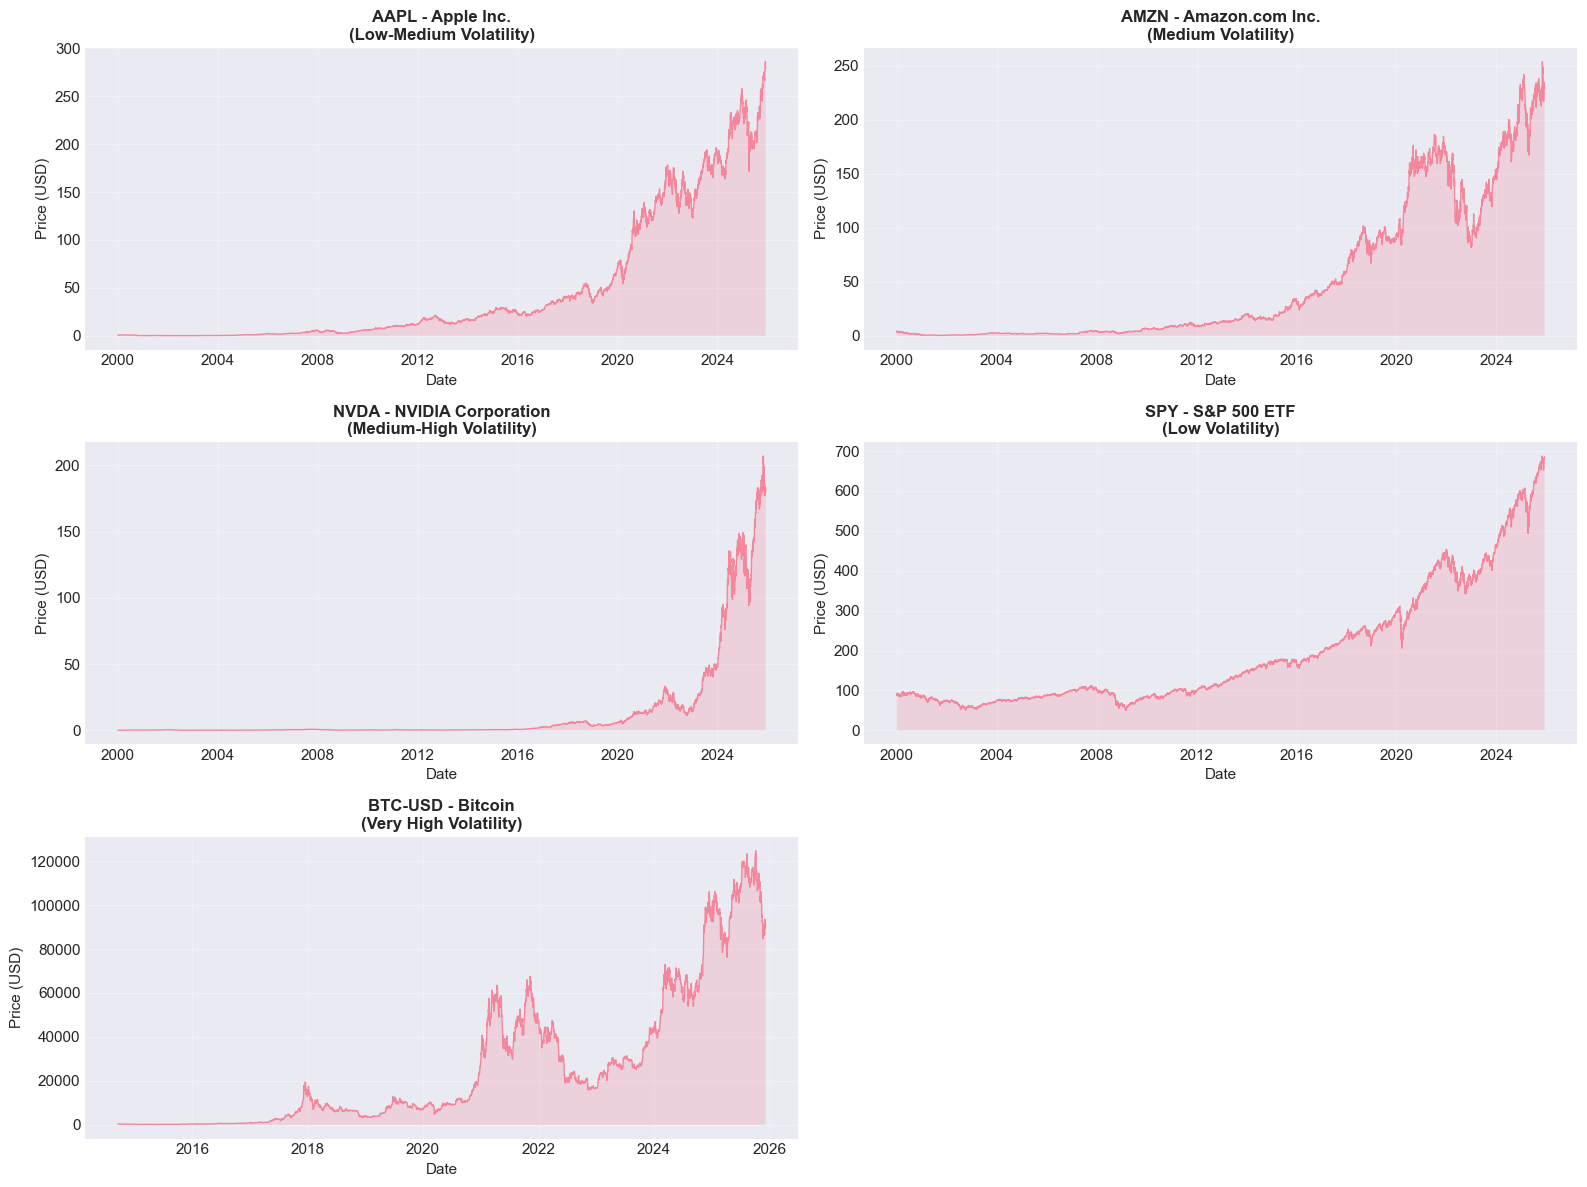

In [212]:
# Plot all assets on separate subplots
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (asset, df) in enumerate(data.items()):
    if df is not None:
        ax = axes[idx]
        ax.plot(df.index, df['Close'], linewidth=1, alpha=0.8)
        ax.set_title(f'{asset} - {ASSETS[asset]["name"]}\n({ASSETS[asset]["volatility"]} Volatility)', 
                     fontsize=12, fontweight='bold')
        ax.set_xlabel('Date')
        ax.set_ylabel('Price (USD)')
        ax.grid(True, alpha=0.3)
        
        # Add shading for better visual
        ax.fill_between(df.index, df['Close'], alpha=0.2)

# Hide extra subplot
if len(data) < 6:
    axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

**Remarks:**

- We can clearly see a general upward mouvement for all the assets. 
- Nvidia had a more explosive growth during last year while other assets had a more exponential one. 
- Bitcoin had a recession period after 2022 but went up during the years after and Amazon had a dip during 2023 but quickly recovered.

**Regarding deep learning models:**

- We should be careful when splitting the data into train and test sets to avoid data leakage due to the upward trend.
- Should we detrend the data before training ?
- Maybe we should avoid having a big lookback window to avoid having too much of the trend in the input features ? 

## 6. Returns Analysis

Compute and analyze returns for each asset. 

The formula for the log-returns is the following:

$ \text{logreturn}_t = \log\!\left(\dfrac{\text{close}_t}{\text{close}_{t-1}}\right) $

In [213]:
# Calculate returns for each asset
returns_data = {}

for asset, df in data.items():
    if df is not None:
        # Calculate log returns
        returns = np.log(df['Close'] / df['Close'].shift(1))
        returns_data[asset] = returns.dropna()

print("[OK] Returns calculated for all assets")

[OK] Returns calculated for all assets


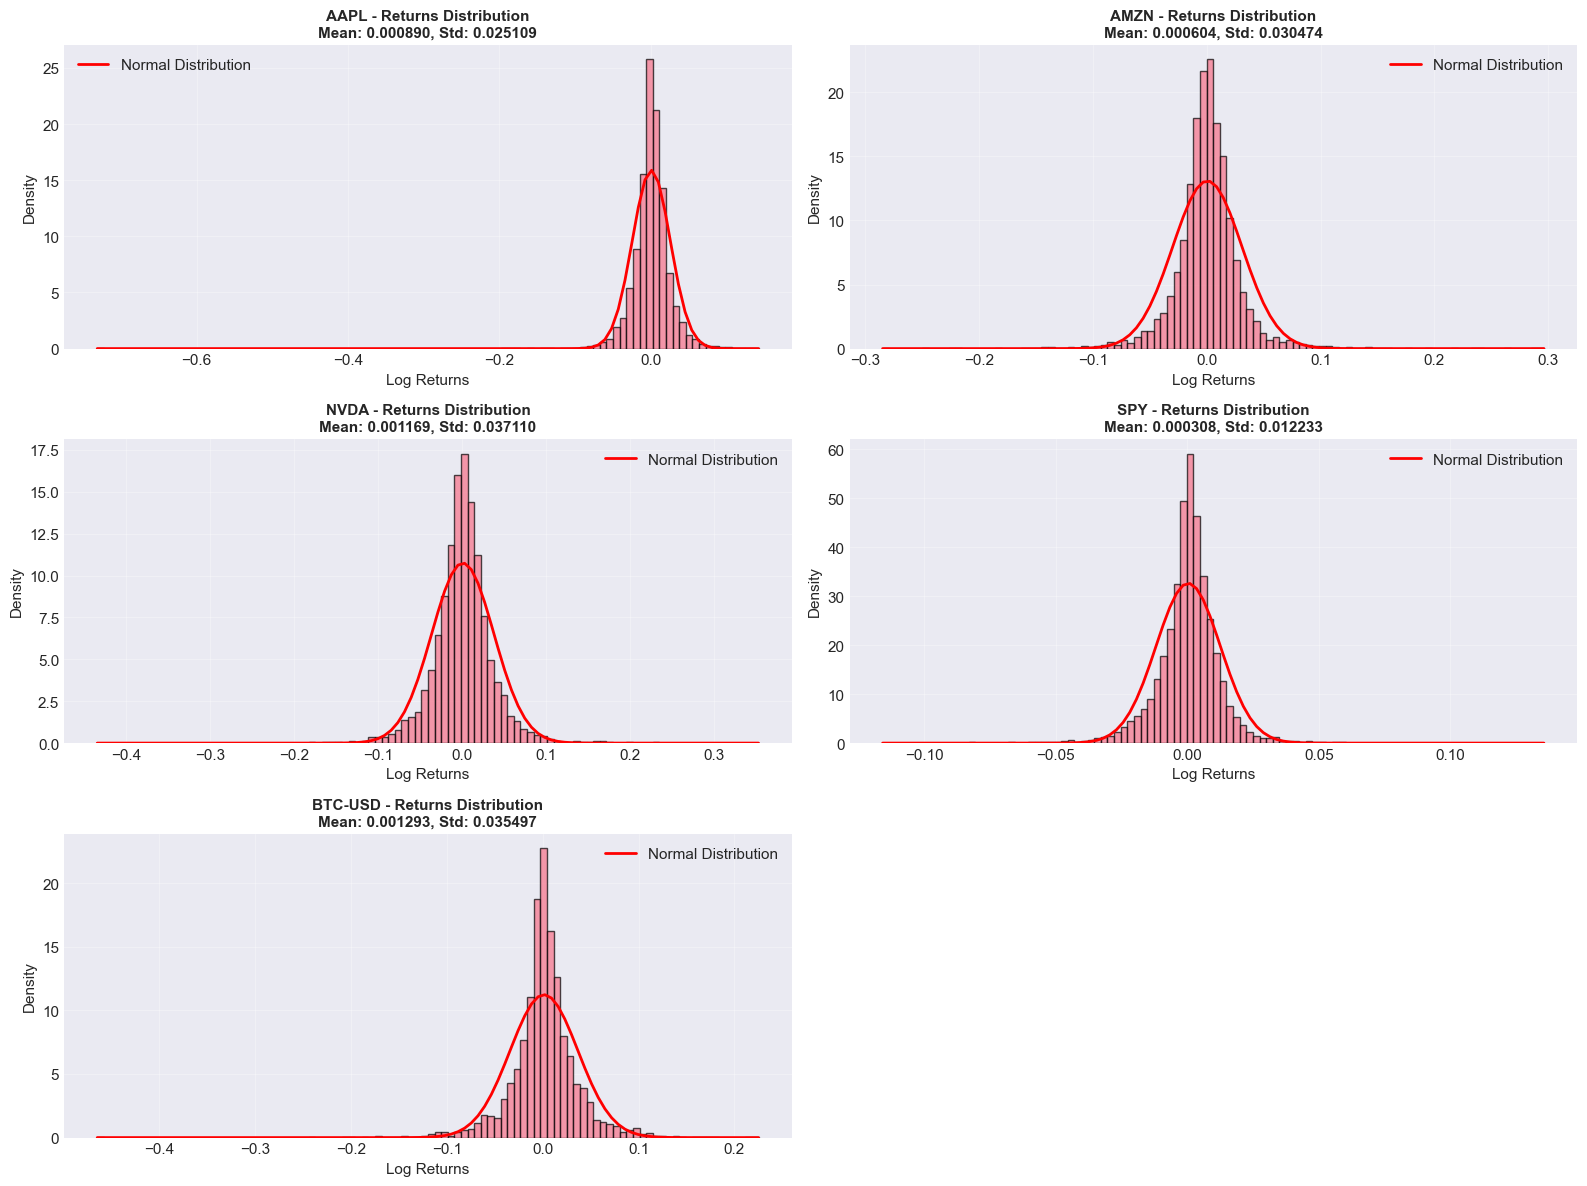

In [214]:
# Plot returns distributions
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (asset, returns) in enumerate(returns_data.items()):
    ax = axes[idx]
    
    # Histogram with KDE
    ax.hist(returns, bins=100, density=True, alpha=0.7, edgecolor='black')
    
    # Fit normal distribution for comparison
    mu, sigma = returns.mean(), returns.std()
    x = np.linspace(returns.min(), returns.max(), 100)
    ax.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal Distribution')
    
    ax.set_title(f'{asset} - Returns Distribution\nMean: {mu:.6f}, Std: {sigma:.6f}', 
                 fontsize=11, fontweight='bold')
    ax.set_xlabel('Log Returns')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide extra subplot
if len(returns_data) < 6:
    axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

In [215]:
# Returns statistics
print("="*60)
print("RETURNS STATISTICS")
print("="*60)

returns_stats = []

for asset, returns in returns_data.items():
    returns_stats.append({
        'Asset': asset,
        'Mean': returns.mean(),
        'Std': returns.std(),
        'Skewness': returns.skew(),
        'Kurtosis': returns.kurtosis(),
        'Min': returns.min(),
        'Max': returns.max()
    })

returns_stats_df = pd.DataFrame(returns_stats)
print(returns_stats_df.to_string(index=False))

RETURNS STATISTICS
  Asset     Mean      Std  Skewness   Kurtosis       Min      Max
   AAPL 0.000890 0.025109 -3.924301 114.436771 -0.731248 0.142617
   AMZN 0.000604 0.030474  0.420263  13.022976 -0.284568 0.296181
   NVDA 0.001169 0.037110 -0.210669  12.904743 -0.434383 0.353574
    SPY 0.000308 0.012233 -0.209115  11.515776 -0.115887 0.135577
BTC-USD 0.001293 0.035497 -0.713282  11.737545 -0.464730 0.225119


**Remarks:**
- the volatility that we observed on the prices is reflected on the returns:  NVDA (3.71%) > BTC (3.55%) > AMZN (3.05%) > AAPL (2.51%) > SPY (1.22%). SPY's low volatility reflects its diversified nature
- All assets show positive daily returns (0.03%-0.13%), confirming a long term upward drift. BTC leads at 0.129% daily (~58% annualized), followed by NVDA at 0.117%
- for appl, there is an extreme value -3.92 for skewness that indicates severe left-tail risk, likely driven by the COVID-19 crash outlier (-73% single-day return). Other assets show moderate negative skew (-0.71 to -0.21) except AMZN (+0.42).
- All assets have very high kurtosis (11-114), meaning extreme returns occur far more frequently than in normal distributions. AAPL's kurtosis of 114 is exceptional, dominated maybe by the COVID outlier.
- The red normal curve fits poorly in all histograms, confirming returns deviate substantially from Gaussian assumptions.

**Regarding deep learning models:**
- the distributions show fat tails which would require a loss functions that don't over-penalize outliers. Should we consider Huber loss or quantile loss instead of MSE ?
- There is a big difference of volatility between asset, so maybe we should use standardScaler separately on each one.

## 7. Volatility Analysis

Calculate and compare realized volatility across assets.

In [216]:
# Calculate rolling volatility (20-day window)
volatility_data = {}

for asset, returns in returns_data.items():
    # Annualized volatility (assuming 252 trading days for stocks, 365 for BTC)
    if asset == 'BTC-USD':
        days_per_year = 365
    else:
        days_per_year = 252  # Trading days per year for stocks
    
    # Rolling standard deviation (20-day window ~1 month)
    rolling_vol = returns.rolling(window=20).std() * np.sqrt(days_per_year)
    volatility_data[asset] = rolling_vol

print("[OK] Rolling volatility calculated for all assets")

[OK] Rolling volatility calculated for all assets


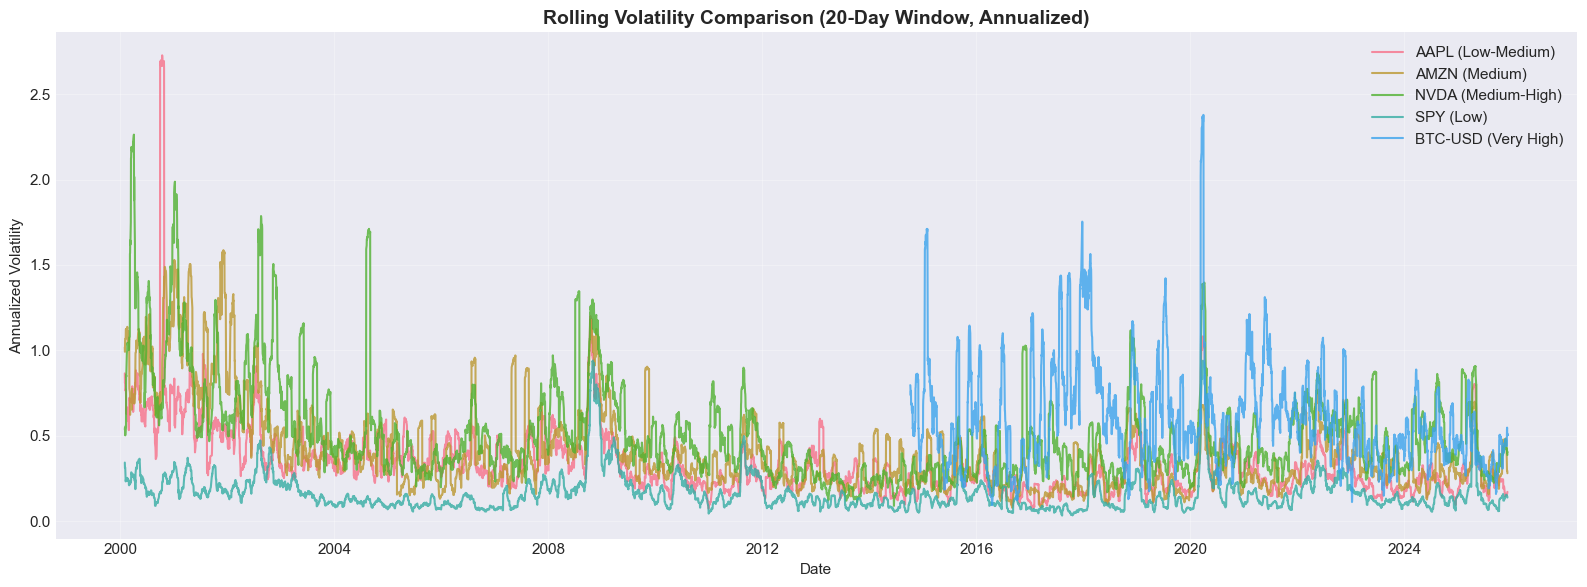

In [217]:
# Plot rolling volatility
fig, ax = plt.subplots(figsize=(16, 6))

for asset, vol in volatility_data.items():
    ax.plot(vol.index, vol, label=f'{asset} ({ASSETS[asset]["volatility"]})', linewidth=1.5, alpha=0.8)

ax.set_title('Rolling Volatility Comparison (20-Day Window, Annualized)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Annualized Volatility')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

AVERAGE VOLATILITY COMPARISON (Annualized)
  Asset Volatility Profile  Mean Vol (%)  Median Vol (%)  Min Vol (%)  Max Vol (%)
    SPY                Low     16.335546       13.755665     3.186047    93.971398
   AAPL         Low-Medium     33.671304       28.999017     7.226978   272.820085
   AMZN             Medium     40.960527       33.653787     7.762184   158.686846
   NVDA        Medium-High     51.278499       43.103893     8.880871   226.366096
BTC-USD          Very High     60.173956       54.326719     9.281159   237.922882


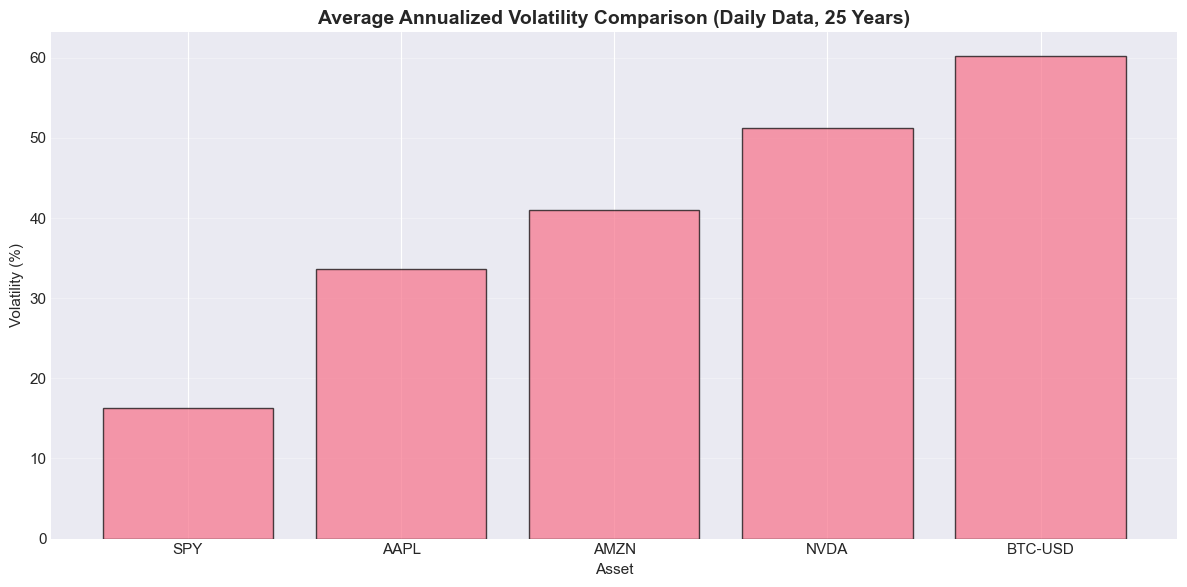

In [218]:
# Average volatility comparison
print("="*70)
print("AVERAGE VOLATILITY COMPARISON (Annualized)")
print("="*70)

vol_summary = []

for asset, vol in volatility_data.items():
    vol_clean = vol.dropna()
    vol_summary.append({
        'Asset': asset,
        'Volatility Profile': ASSETS[asset]['volatility'],
        'Mean Vol (%)': vol_clean.mean() * 100,
        'Median Vol (%)': vol_clean.median() * 100,
        'Min Vol (%)': vol_clean.min() * 100,
        'Max Vol (%)': vol_clean.max() * 100
    })

vol_summary_df = pd.DataFrame(vol_summary)
vol_summary_df = vol_summary_df.sort_values('Mean Vol (%)')
print(vol_summary_df.to_string(index=False))

# Bar chart comparison
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(vol_summary_df['Asset'], vol_summary_df['Mean Vol (%)'], alpha=0.7, edgecolor='black')
ax.set_title('Average Annualized Volatility Comparison (Daily Data, 25 Years)', fontsize=14, fontweight='bold')
ax.set_xlabel('Asset')
ax.set_ylabel('Volatility (%)')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

**Remarks:**

- Bitcoin is clearly the most volatile asset at 60.2%, about four times higher than SPY's 16.3%.
-  NVDA comes in second with 51.3%, followed by Amazon and Apple. 
- We can see massive volatility spikes during major crises - Apple hit 273% during the COVID crash in March 2020, and Bitcoin shows similar extreme ranges during the 2017-2018 and 2021-2022 crypto cycles. 
- the mean is higher than the median for all assets, which tells us that volatility usually stays relatively low but occasionally explodes during market stress
- historical chart clearly shows these periods: the dot-com crash, 2008 financial crisis, COVID pandemic, and even the recent AI boom in 2023-2024.

**Regarding deep learning models:**

- we can observe different volatility regimes for all assets, so what works during calm periods might fail during crises
- This means our training data should cover multiple crisis periods so the model doesn't just learn normal conditions
- We'll also need to normalize each asset by its own historical volatility, since a 5% move in Bitcoin is routine but would be extreme for SPY. Maybe we should use shorter lookback periods during volatile times and longer ones during calm markets ? 

## 8. Correlation Analysis

Analyze correlations between assets.

CORRELATION MATRIX (Returns)
           AAPL    AMZN    NVDA     SPY  BTC-USD
AAPL     1.0000  0.3678  0.4117  0.5533   0.1769
AMZN     0.3678  1.0000  0.3654  0.5009   0.1681
NVDA     0.4117  0.3654  1.0000  0.5477   0.1994
SPY      0.5533  0.5009  0.5477  1.0000   0.2373
BTC-USD  0.1769  0.1681  0.1994  0.2373   1.0000


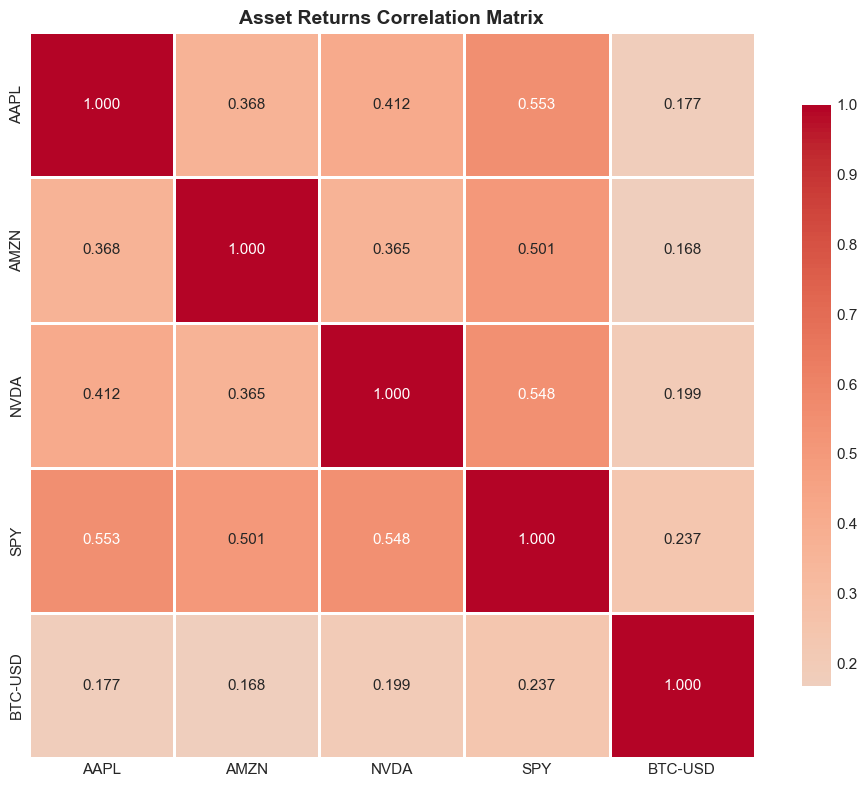


CORRELATION INSIGHTS
High correlation (>0.5): Assets tend to move together
Low correlation (<0.3): Assets move independently
Negative correlation (<0): Assets move in opposite directions


In [219]:
# Create DataFrame with all returns aligned
returns_data_clean = {}
for asset, returns in returns_data.items():
    # Convert to timezone-naive if timezone-aware
    if hasattr(returns.index, 'tz') and returns.index.tz is not None:
        returns_data_clean[asset] = returns.tz_localize(None)
    else:
        returns_data_clean[asset] = returns

returns_df = pd.DataFrame(returns_data_clean)

# Calculate correlation matrix
correlation_matrix = returns_df.corr()

print("="*60)
print("CORRELATION MATRIX (Returns)")
print("="*60)
print(correlation_matrix.round(4))

# Plot correlation heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
ax.set_title('Asset Returns Correlation Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Interpretation
print("\n" + "="*60)
print("CORRELATION INSIGHTS")
print("="*60)
print("High correlation (>0.5): Assets tend to move together")
print("Low correlation (<0.3): Assets move independently")
print("Negative correlation (<0): Assets move in opposite directions")

**Remarks**:
- bitcoin is overall weakly correlated with traditional stocks and so it provides substantial diversification 
- BTC shows only 24% SPY correlation

**Regarding deep learning models**:
- Maybe bitcoin requires separate feature engineering due to weak equity correlation
- We suppose that we cannot rely on stock market indicators (SPY, sector ETFs) as primary BTC predictors (training of btc and validating on stocks or vice versa may not work well)
- there is a moderate correlation between the three stocks (AAPL, AMZN, NVDA) and SPY (0.36-0.55), so maybe we can use SPY as a feature for these three stocks, or training on SPY and validating on the three stocks or vice versa may work well

## 9. Stationarity Tests

Test for stationarity using Augmented Dickey-Fuller (ADF) test.

In [220]:
# Perform ADF test on prices and returns
print("="*70)
print("AUGMENTED DICKEY-FULLER TEST RESULTS")
print("="*70)
print("Null Hypothesis: Series is non-stationary")
print("Alternative: Series is stationary")
print("Rejection threshold: p-value < 0.05")
print("="*70)

adf_results = []

for asset, df in data.items():
    if df is not None:
        # Test on prices
        adf_price = adfuller(df['Close'].dropna(), autolag='AIC')
        
        # Test on returns
        returns = returns_data[asset]
        adf_returns = adfuller(returns.dropna(), autolag='AIC')
        
        print(f"\n{asset}:")
        print(f"Prices:")
        print(f"ADF Statistic: {adf_price[0]:.4f}")
        print(f"p-value: {adf_price[1]:.4f}")
        print(f"Result: {'Stationary' if adf_price[1] < 0.05 else 'Non-Stationary'}")
        
        print(f"Returns:")
        print(f"ADF Statistic: {adf_returns[0]:.4f}")
        print(f"p-value: {adf_returns[1]:.4f}")
        print(f"Result: {'Stationary' if adf_returns[1] < 0.05 else 'Non-Stationary'}")
        
        adf_results.append({
            'Asset': asset,
            'Price_ADF': adf_price[0],
            'Price_pvalue': adf_price[1],
            'Price_Stationary': 'Yes' if adf_price[1] < 0.05 else 'No',
            'Returns_ADF': adf_returns[0],
            'Returns_pvalue': adf_returns[1],
            'Returns_Stationary': 'Yes' if adf_returns[1] < 0.05 else 'No'
        })

# Summary table
adf_df = pd.DataFrame(adf_results)
print("\n" + "="*70)
print("STATIONARITY SUMMARY")
print("="*70)
print(adf_df.to_string(index=False))

AUGMENTED DICKEY-FULLER TEST RESULTS
Null Hypothesis: Series is non-stationary
Alternative: Series is stationary
Rejection threshold: p-value < 0.05

AAPL:
Prices:
ADF Statistic: 2.6700
p-value: 0.9991
Result: Non-Stationary
Returns:
ADF Statistic: -18.0893
p-value: 0.0000
Result: Stationary

AAPL:
Prices:
ADF Statistic: 2.6700
p-value: 0.9991
Result: Non-Stationary
Returns:
ADF Statistic: -18.0893
p-value: 0.0000
Result: Stationary

AMZN:
Prices:
ADF Statistic: 1.0957
p-value: 0.9952
Result: Non-Stationary
Returns:
ADF Statistic: -12.8191
p-value: 0.0000
Result: Stationary

AMZN:
Prices:
ADF Statistic: 1.0957
p-value: 0.9952
Result: Non-Stationary
Returns:
ADF Statistic: -12.8191
p-value: 0.0000
Result: Stationary

NVDA:
Prices:
ADF Statistic: 3.3483
p-value: 1.0000
Result: Non-Stationary
Returns:
ADF Statistic: -13.9249
p-value: 0.0000
Result: Stationary

NVDA:
Prices:
ADF Statistic: 3.3483
p-value: 1.0000
Result: Non-Stationary
Returns:
ADF Statistic: -13.9249
p-value: 0.0000
Result

**Remarks:**

The ADF test confirms what we expected - all price series are non-stationary with p-values near 1.0, meaning they have strong upward trends over the 25-year period. In contrast, all return series are stationary with p-values essentially zero, showing they fluctuate around a stable mean. This makes sense because stock prices grow over time (AAPL went from $1 to $200+), but daily returns just bounce around between -10% and +10% with consistent behavior throughout the entire period.

**Regarding deep learning models:**

We should work with returns instead of raw prices for our models. Returns have stable statistical properties over time, which is exactly what machine learning algorithms need. If we tried to use prices directly, the model would just learn the upward trend rather than actual predictive patterns. Plus, using returns means our technical indicators will work properly and the model should generalize better to future data. (at least we hope so so far)

## 10. Autocorrelation Analysis

Examine autocorrelation in returns to detect patterns.

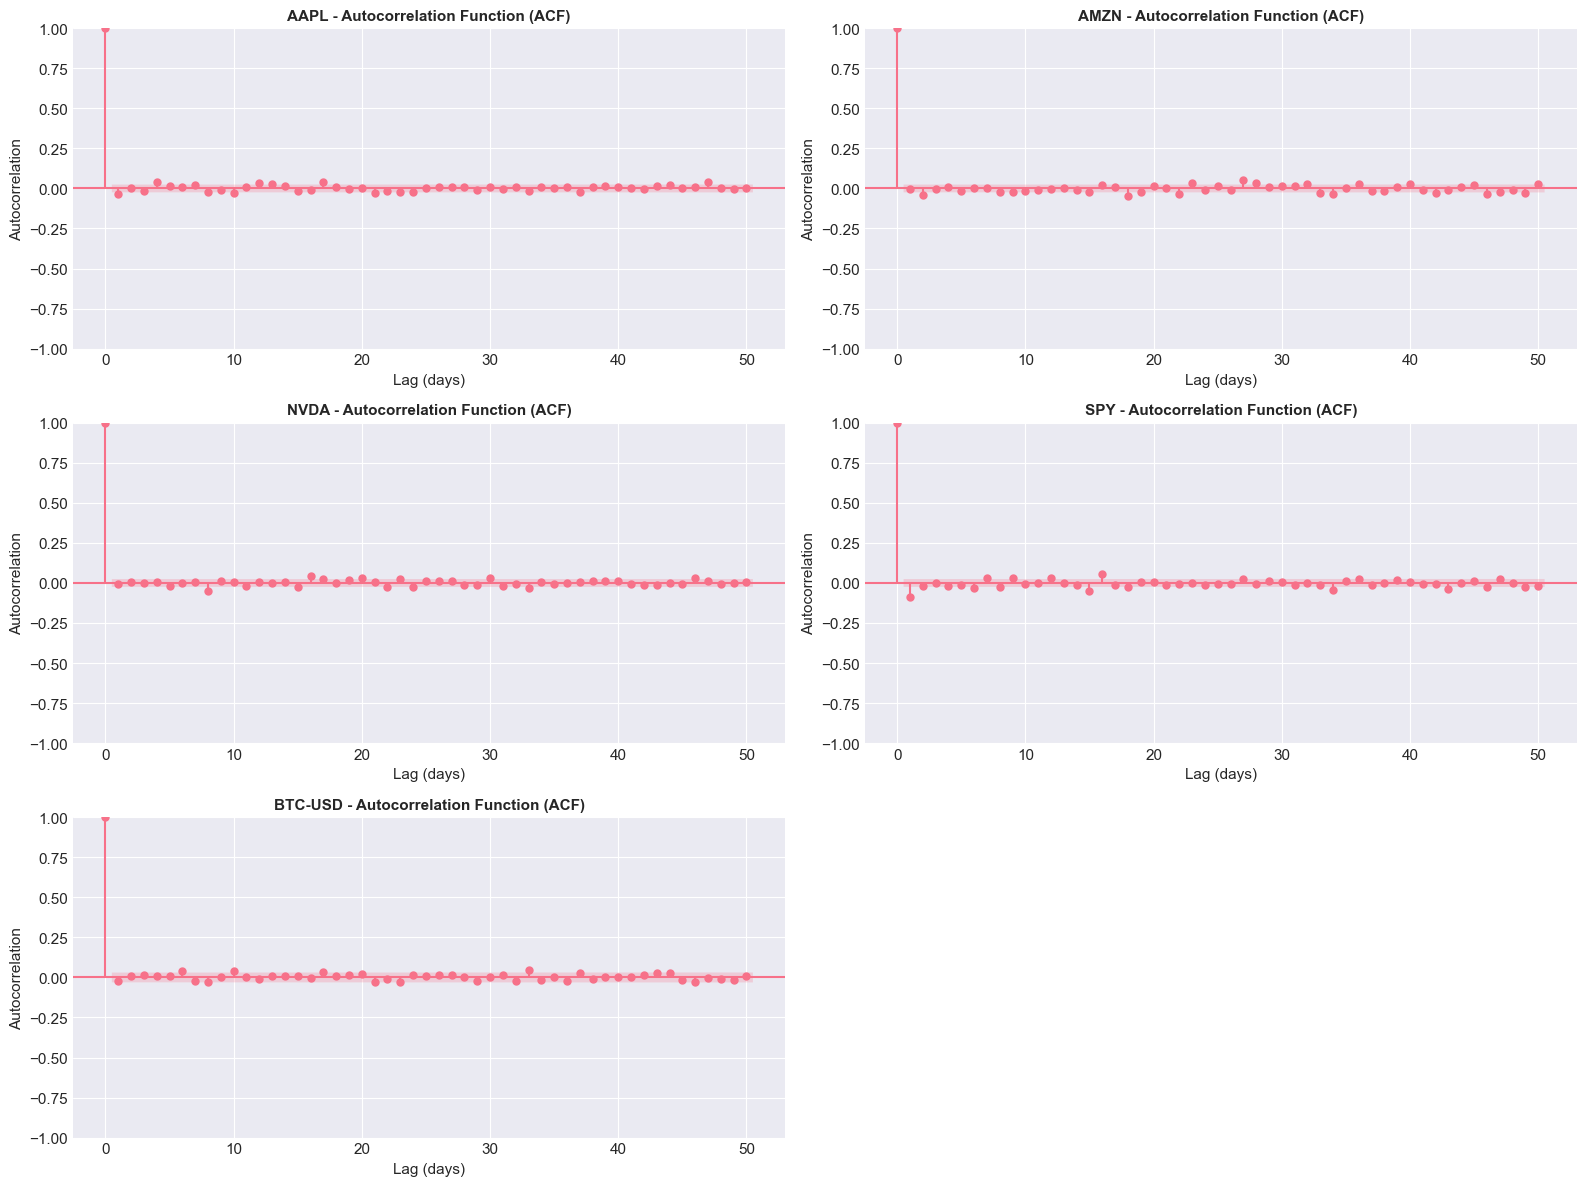


Interpretation:
- Values within blue shaded area suggest no significant autocorrelation
- Values outside suggest predictable patterns (momentum or mean reversion)


In [222]:
# Plot autocorrelation for returns
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()


for idx, (asset, returns) in enumerate(returns_data.items()):
    ax = axes[idx]
    plot_acf(returns.dropna(), lags=50, ax=ax, alpha=0.05)
    ax.set_title(f'{asset} - Autocorrelation Function (ACF)', fontsize=11, fontweight='bold')
    ax.set_xlabel('Lag (days)')
    ax.set_ylabel('Autocorrelation')

# Hide extra subplot
if len(returns_data) < 6:
    axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Values within blue shaded area suggest no significant autocorrelation")
print("- Values outside suggest predictable patterns (momentum or mean reversion)")

**Remarks:**

All five assets show basically no autocorrelation in their daily returns as almost all the values stay within the blue confidence bands across all 50 lags. This tells us that past returns don't predict future returns, which is what we'd expect from efficient markets. Bitcoin behaves the same way as the stocks here, even though it's supposed to be less mature as a market.

**Regarding deep learning models:**

Since there's no obvious pattern in how past returns predict future ones, we can't just use simple lagged returns as features. We'll need to get creative with feature engineering, maybe with things like technical indicators, rolling volatility, volume patterns, and cross-asset relationships. The good news is that while returns themselves don't show autocorrelation, volatility tends to cluster (high volatility follows high volatility), which is something our models might be able to learn. The lack of simple patterns actually makes this a more interesting deep learning problem.

## 11. Summary and considerations for the rest of the project

Compile all findings from the exploratory data analysis.

- assets have a differents volatilies, and should be normalized/scaled individually.
- the correlation matrix showed that some correlated assets could be used to generalize on others (amazon, apple, nvidia), but bitcoin remains uncorrelated to the rest and a model trained on btc and tested on the others assets (and vice versa) would perform poorly.
- we should not use closing prices as they are not stationary + there is an upward trend. We should use returns with a relatively smaller lookback window to avoid this problem.
- the train/val/test should be chronological to avoid lookahead bias
- we should try to handle outliers
- as returns show little autocorrelation we might need to try different indicators as inputs. However since volatitly clusters, a deep learning model might be able to predict the mouvement using that same volatility.